In [1]:
# try load torch dataset from npy files
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

# Cell 1: Import necessary libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
import time
from progress.bar import IncrementalBar


# Custom modules (assuming they are in the same directory or properly installed as packages)
from dataset import Cityscapes, Facades, Maps, PM25
from dataset import transforms as T
from dataset import transforms_multi_array as T_a
from gan.generator import UnetGenerator, Generator
from gan.discriminator import ConditionalDiscriminator
from gan.criterion import GeneratorLoss, DiscriminatorLoss
from gan.utils import Logger, initialize_weights

In [9]:
import os
os.chdir('E:/Coding/pix2pix_pytorch/')

In [47]:
# Cell 2: Define parameters (replacing argparse)
epochs = 200  # Number of epochs
# dataset_name = "facades"  # Name of the dataset: ['facades', 'maps', 'cityscapes']
batch_size = 1  # Size of the batches
learning_rate = 0.0002  # Adam's learning rate 0.0002
g_lr = 0.002  # Generator's learning rate
d_lr = 0.00001  # Discriminator's learning rate
# Cell 3: Set up device and transformations
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')

transforms = T_a.Compose([T_a.Resize((256, 256)),
                          T_a.HorizontalFlip(0.5),
                          T_a.VerticalFlip(0.5),
                          T_a.ToTensor()])


In [48]:
# Cell 4: Define models, optimizers, and loss functions
print('Defining models!')
generator = UnetGenerator().to(device)
discriminator = ConditionalDiscriminator().to(device)

g_optimizer = torch.optim.Adam(generator.parameters(), lr=g_lr, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=d_lr, betas=(0.5, 0.999))

g_criterion = GeneratorLoss(alpha=100)
d_criterion = DiscriminatorLoss()

Defining models!


In [49]:
root = 'E:/Coding/pix2pix_pytorch/'
dataset = PM25(root=root, transform=transforms, download=False, mode='train')

In [50]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [51]:
# Cell 6: Training loop
print('Start of training process!')
logger = Logger(filename='pm25')
for epoch in range(epochs):
    ge_loss = 0.
    de_loss = 0.
    start = time.time()
    bar = IncrementalBar(f'[Epoch {epoch+1}/{epochs}]', max=len(dataloader))
    for x, real in dataloader:
        x = x.to(device)
        real = real.to(device)

        # Generator's loss
        fake = generator(x)
        fake_pred = discriminator(fake, x)
        g_loss = g_criterion(fake, real, fake_pred)

        # Discriminator's loss
        fake = generator(x).detach()
        fake_pred = discriminator(fake, x)
        real_pred = discriminator(real, x)
        d_loss = d_criterion(fake_pred, real_pred)

        # Generator's params update
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        # Discriminator's params update
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Add batch losses
        ge_loss += g_loss.item()
        de_loss += d_loss.item()
        bar.next()
    bar.finish()  

    # Obtain per epoch losses
    g_loss = ge_loss / len(dataloader)
    d_loss = de_loss / len(dataloader)

    # Count timeframe
    end = time.time()
    tm = (end - start)
    logger.add_scalar('generator_loss', g_loss, epoch+1)
    logger.add_scalar('discriminator_loss', d_loss, epoch+1)
    logger.save_weights(generator.state_dict(), 'generator')
    logger.save_weights(discriminator.state_dict(), 'discriminator')
    print("[Epoch %d/%d] [G loss: %.3f] [D loss: %.3f] ETA: %.3fs [Device: %s]" % (epoch+1, epochs, g_loss, d_loss, tm, x.device))
logger.close()
print('End of training process!')

Start of training process!
[Epoch 1/200] [G loss: 8.516] [D loss: 0.200] ETA: 8.187s [Device: cuda:0]
[Epoch 2/200] [G loss: 6.478] [D loss: 0.047] ETA: 8.113s [Device: cuda:0]
[Epoch 3/200] [G loss: 7.335] [D loss: 0.028] ETA: 7.856s [Device: cuda:0]
[Epoch 4/200] [G loss: 7.934] [D loss: 0.015] ETA: 7.922s [Device: cuda:0]
[Epoch 5/200] [G loss: 8.166] [D loss: 0.011] ETA: 7.822s [Device: cuda:0]
[Epoch 6/200] [G loss: 8.606] [D loss: 0.007] ETA: 7.676s [Device: cuda:0]
[Epoch 7/200] [G loss: 8.888] [D loss: 0.005] ETA: 7.713s [Device: cuda:0]
[Epoch 8/200] [G loss: 9.164] [D loss: 0.004] ETA: 7.748s [Device: cuda:0]
[Epoch 9/200] [G loss: 9.363] [D loss: 0.003] ETA: 7.789s [Device: cuda:0]
[Epoch 10/200] [G loss: 9.718] [D loss: 0.003] ETA: 7.899s [Device: cuda:0]
[Epoch 11/200] [G loss: 9.933] [D loss: 0.002] ETA: 7.780s [Device: cuda:0]
[Epoch 12/200] [G loss: 10.038] [D loss: 0.002] ETA: 7.635s [Device: cuda:0]
[Epoch 13/200] [G loss: 9.786] [D loss: 0.003] ETA: 7.719s [Device: c

In [52]:
# print current working directory
import os
print(os.getcwd())

E:\Coding\pix2pix_pytorch


In [53]:
# Cell 7: Load the saved model weights
# Define the paths where the model weights are saved

generator_weights_path = os.getcwd()+'/runs/generator.pt'
discriminator_weights_path = os.getcwd()+'/runs/discriminator.pt'

# Load the saved weights
generator.load_state_dict(torch.load(generator_weights_path))
discriminator.load_state_dict(torch.load(discriminator_weights_path))
print("Model weights loaded successfully!")

Model weights loaded successfully!


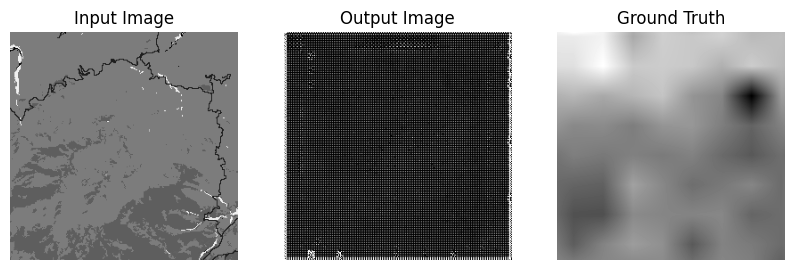

In [55]:
# Cell 8: Run the model on test data and print predictions
import matplotlib.pyplot as plt
import numpy as np

def imshow(image, title=None, ax=None):
    """
    Display a numpy array as an image.

    Parameters:
    - image (numpy array): The input image. Can be 2D (H, W) or 3D (H, W, C).
    - title (str): Title of the image.
    - ax (matplotlib.axes.Axes): The axes on which to plot the image.
    """
    image = image.cpu()
    # Check if the input is 2D or 3D
    if image.ndim == 3 and image.shape[2] > 1:
        # If the input is 3D, use the first channel for display
        image = image[ 0, :, :]
    
    # If the input is 3D but with only 1 channel, squeeze the channel dimension
    elif image.ndim == 3 and image.shape[2] == 1:
        image = image.squeeze(2)
    
    if ax is None:
        ax = plt.gca()
    ax.imshow(image, cmap='gray')  # Use grayscale for single-channel image
    if title is not None:
        ax.set_title(title)
    ax.axis('off')

# Load some test data
dataset = PM25(root=root, transform=transforms, download=False, mode='test')
test_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Get a batch of test data
data_iter = iter(test_loader)
inputs, _ = next(data_iter)  # Use the built-in next() function
inputs = inputs.to(device)

# Generate predictions
with torch.no_grad():
    outputs = generator(inputs)

# Plot the input and output images
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
imshow(inputs[0], title='Input Image', ax=ax[0])
imshow(outputs[0], title='Output Image', ax=ax[1])
imshow(_[0], title='Ground Truth', ax=ax[2])
plt.show()

In [21]:
# Check if the input is 2D or 3D
image = inputs[0].cpu()
if image.ndim == 3 and image.shape[2] > 1:
# If the input is 3D, use the first channel for display
    image = image[0, :, :]
    
    # If the input is 3D but with only 1 channel, squeeze the channel dimension
elif image.ndim == 3 and image.shape[2] == 1:
    image = image.squeeze(2)

In [41]:
for name, param in generator.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.grad.norm()}")



encoder1.weight: 0.014605609700083733
encoder1.bias: 0.06654109060764313
encoder2.conv.weight: 0.007501885294914246
encoder2.conv.bias: 2.0564325353689128e-08
encoder2.bn.weight: 0.00018329588056076318
encoder2.bn.bias: 0.0005131714860908687
encoder3.conv.weight: 0.0020061589311808348
encoder3.conv.bias: 6.074209885076343e-11
encoder3.bn.weight: 6.0408372519304976e-05
encoder3.bn.bias: 0.00014242513861972839
encoder4.conv.weight: 0.0017271204851567745
encoder4.conv.bias: 9.97203448288575e-12
encoder4.bn.weight: 0.00012994158896617591
encoder4.bn.bias: 0.00010064819070976228
encoder5.conv.weight: 0.005228859372437
encoder5.conv.bias: 7.289498865636901e-12
encoder5.bn.weight: 0.0001989029551623389
encoder5.bn.bias: 9.446043259231374e-05
encoder6.conv.weight: 0.007348144892603159
encoder6.conv.bias: 8.788781334645446e-12
encoder6.bn.weight: 0.00020077111548744142
encoder6.bn.bias: 0.00011911426554434001
encoder7.conv.weight: 0.007546619977802038
encoder7.conv.bias: 2.075631853892812e-11
e